## Import all packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels
import folium
from folium import plugins
from folium.plugins import HeatMap
from datetime import datetime #for working with times objects
from datetime import timedelta #for working with times objects
from datetime import date
import math
import random
import swifter
import json
from geopandas.tools import geocode

In [2]:
#conda install -c conda-forge anaconda geopandas swifter -y

## Import data sets

In [3]:
#read in the data

chi_data = pd.read_csv("chicago_2017.csv")
chi_weather = pd.read_csv("weather_hourly_chicago.csv")

## General information about the raw data

### chicago_2017 data set

In [4]:
#chi_data.info()

In [5]:
#chi_data.describe()

In [105]:
#chi_data.head()

### weather_hourly_chicago data set

In [7]:
#chi_weather.info()

In [8]:
#chi_weather.describe()

In [107]:
#chi_weather.head()

## Add date time features to chi_data

In [10]:
chi_data['start_time']= pd.to_datetime(chi_data['start_time'])
chi_data['end_time'] = pd.to_datetime(chi_data['end_time'])

In [11]:
chi_data.sort_values(['start_time'], inplace = True) #Sorts the values by date 

In [12]:
chi_data["Date"] = chi_data['start_time'].swifter.apply(lambda dt: dt.date())
chi_data["Month"] = chi_data['start_time'].swifter.apply(lambda dt: dt.month)
chi_data["Week"] = chi_data['start_time'].swifter.apply(lambda dt: dt.isocalendar()[1])
chi_data["Day"] = chi_data['start_time'].swifter.apply(lambda dt: dt.day)
chi_data["Hour"] = chi_data['start_time'].swifter.apply(lambda dt: dt.hour)
chi_data["Weekday"] = chi_data['start_time'].swifter.apply(lambda dt: dt.weekday())
chi_data['Duration'] = (chi_data['end_time']-chi_data['start_time'])
chi_data["Duration_sec"] = chi_data["Duration"].swifter.apply(lambda x: x.total_seconds())
chi_data["IsWeekday"] = chi_data["Weekday"].swifter.apply(lambda x: 1 if x < 5 else 0)
#chi_data.head()

Dask Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/8 [00:00<?, ?it/s]

## Add date weather features to chi_weather_2017

In [13]:
chi_weather['date_time']=pd.to_datetime(chi_weather['date_time'])

In [176]:
first_date = datetime(year=2017, day=1, month=1)
last_date = datetime(year=2018, day=1, month=1)
chi_weather_2017 = chi_weather[(chi_weather['date_time']>=first_date)&(chi_weather["date_time"] <= last_date)]

In [15]:
chi_weather_2017.sort_values(by = "date_time", inplace = True) #sort the values by date time

<ipython-input-15-dd50bfe8e1ce>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chi_weather_2017.sort_values(by = "date_time", inplace = True) #sort the values by date time


In [16]:
chi_weather_2017["Date"] = chi_weather_2017['date_time'].swifter.apply(lambda dt: dt.date())
chi_weather_2017['Month']= chi_weather_2017["date_time"].swifter.apply(lambda dt: dt.month)
chi_weather_2017["Week"] = chi_weather_2017['date_time'].swifter.apply(lambda dt: dt.isocalendar()[1])
chi_weather_2017["Hour"] = chi_weather_2017['date_time'].swifter.apply(lambda dt: dt.hour)
chi_weather_2017["Weekday"] = chi_weather_2017['date_time'].swifter.apply(lambda dt: dt.weekday())
chi_weather_2017["mean_temp"] = (chi_weather_2017['max_temp']+chi_weather_2017['min_temp'])/2
#chi_weather_2017.head()

Pandas Apply:   0%|          | 0/8728 [00:00<?, ?it/s]

<ipython-input-16-54fe59a6475f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chi_weather_2017["Date"] = chi_weather_2017['date_time'].swifter.apply(lambda dt: dt.date())


Pandas Apply:   0%|          | 0/8728 [00:00<?, ?it/s]

<ipython-input-16-54fe59a6475f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chi_weather_2017['Month']= chi_weather_2017["date_time"].swifter.apply(lambda dt: dt.month)


Pandas Apply:   0%|          | 0/8728 [00:00<?, ?it/s]

<ipython-input-16-54fe59a6475f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chi_weather_2017["Week"] = chi_weather_2017['date_time'].swifter.apply(lambda dt: dt.isocalendar()[1])


Pandas Apply:   0%|          | 0/8728 [00:00<?, ?it/s]

<ipython-input-16-54fe59a6475f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chi_weather_2017["Hour"] = chi_weather_2017['date_time'].swifter.apply(lambda dt: dt.hour)


Pandas Apply:   0%|          | 0/8728 [00:00<?, ?it/s]

<ipython-input-16-54fe59a6475f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chi_weather_2017["Weekday"] = chi_weather_2017['date_time'].swifter.apply(lambda dt: dt.weekday())
<ipython-input-16-54fe59a6475f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chi_weather_2017["mean_temp"] = (chi_weather_2017['max_temp']+chi_weather_2017['min_temp'])/2


# `Data collection and preparation`

In [17]:
chi_data['Duration_sec'].describe()

count    3.829014e+06
mean     9.556289e+02
std      1.569593e+03
min     -3.120000e+03
25%      4.060000e+02
50%      6.850000e+02
75%      1.146000e+03
max      8.633800e+04
Name: Duration_sec, dtype: float64

In [18]:
chi_data['Duration_sec'].value_counts()

300.0      55446
360.0      54179
420.0      51548
240.0      50249
480.0      47799
           ...  
29935.0        1
12393.0        1
15424.0        1
30265.0        1
26519.0        1
Name: Duration_sec, Length: 16265, dtype: int64

In [19]:
chi_data.sort_values (by= 'Duration_sec')

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,Date,Month,Week,Day,Hour,Weekday,Duration,Duration_sec,IsWeekday
3448503,2017-11-05 01:56:00,2017-11-05 01:04:00,295,231,Broadway & Argyle St,Sheridan Rd & Montrose Ave,6085,Subscriber,2017-11-05,11,44,5,1,6,-1 days +23:08:00,-3120.0,0
3448505,2017-11-05 01:54:00,2017-11-05 01:06:00,321,197,Wabash Ave & 9th St,Michigan Ave & Madison St,5707,Customer,2017-11-05,11,44,5,1,6,-1 days +23:12:00,-2880.0,0
3448506,2017-11-05 01:54:00,2017-11-05 01:06:00,321,197,Wabash Ave & 9th St,Michigan Ave & Madison St,2083,Customer,2017-11-05,11,44,5,1,6,-1 days +23:12:00,-2880.0,0
3448504,2017-11-05 01:54:00,2017-11-05 01:06:00,321,197,Wabash Ave & 9th St,Michigan Ave & Madison St,4905,Customer,2017-11-05,11,44,5,1,6,-1 days +23:12:00,-2880.0,0
3448500,2017-11-05 01:59:00,2017-11-05 01:13:00,327,300,Sheffield Ave & Webster Ave,Broadway & Barry Ave,6061,Subscriber,2017-11-05,11,44,5,1,6,-1 days +23:14:00,-2760.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440556,2017-06-30 14:32:51,2017-07-01 14:27:16,84,508,Milwaukee Ave & Grand Ave,Central Park Ave & North Ave,4914,Customer,2017-06-30,6,26,30,14,4,0 days 23:54:25,86065.0,1
1278923,2017-05-01 15:00:41,2017-05-02 14:55:37,328,420,Ellis Ave & 58th St,Ellis Ave & 55th St,1146,Subscriber,2017-05-01,5,18,1,15,0,0 days 23:54:56,86096.0,1
877116,2017-06-04 13:07:01,2017-06-05 13:04:05,438,438,Central Park Ave & Ogden Ave,Central Park Ave & Ogden Ave,735,Customer,2017-06-04,6,22,4,13,6,0 days 23:57:04,86224.0,0
21192,2017-03-27 20:09:57,2017-03-28 20:07:30,31,46,Franklin St & Chicago Ave,Wells St & Walton St,4563,Customer,2017-03-27,3,13,27,20,0,0 days 23:57:33,86253.0,1


In [20]:
chi_data_60sec_trips=chi_data[chi_data.Duration_sec == 60]
chi_data_60sec_trips.count()

#checking quantity of very short trips

start_time            2362
end_time              2362
start_station_id      2362
end_station_id        2362
start_station_name    2362
end_station_name      2362
bike_id               2362
user_type             2362
Date                  2362
Month                 2362
Week                  2362
Day                   2362
Hour                  2362
Weekday               2362
Duration              2362
Duration_sec          2362
IsWeekday             2362
dtype: int64

In [21]:
chi_data_idcheck = chi_data[['start_station_id', 'start_station_name']]

In [22]:
grouped_chi_data = chi_data_idcheck.groupby(['start_station_id'])
grouped_chi_data = grouped_chi_data.agg({"start_station_name": "nunique"})

grouped_chi_data = grouped_chi_data. reset_index()

print(grouped_chi_data)

     start_station_id  start_station_name
0                   2                   1
1                   3                   1
2                   4                   1
3                   5                   1
4                   6                   1
..                ...                 ...
580               622                   1
581               623                   1
582               624                   1
583               625                   1
584               626                   1

[585 rows x 2 columns]


In [23]:
bad_ids = grouped_chi_data[grouped_chi_data['start_station_name']>1]
bad_ids
#listing IDs that are associated with multiple names

,start_station_id,start_station_name
13,17,2
49,53,2
67,75,2
298,321,2
401,437,2
443,480,2
503,544,2
533,574,2


In [24]:
#chi_data.to_csv('cleanedtrips.csv')

# `Descriptive analystics`

## Overview Data

In [25]:
stations = len(grouped_chi_data['start_station_id'])
print("The overall number of stations is {}".format(stations))

bikes = len(chi_data['bike_id'].unique())
print("The overall number of bikes is {}".format(bikes))

trips = chi_data['start_time'].count()
print("The overall number of trips is {}".format(trips))


The overall number of stations is 585
The overall number of bikes is 6243
The overall number of trips is 3829014


## Temporal demand patterns

### Bike rentals

#### Bike rentals per month

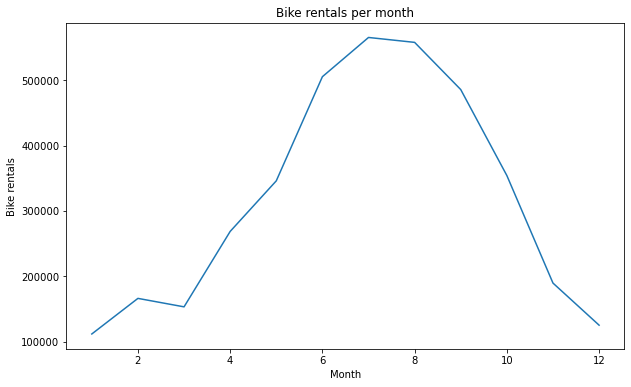

In [26]:
rentals_month = chi_data.groupby(['Month'])['bike_id'].count()
rentals_month = pd.DataFrame(rentals_month)

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(rentals_month)
ax.set_title('Bike rentals per month')
ax.set_xlabel('Month')
ax.set_ylabel("Bike rentals")
plt.show()

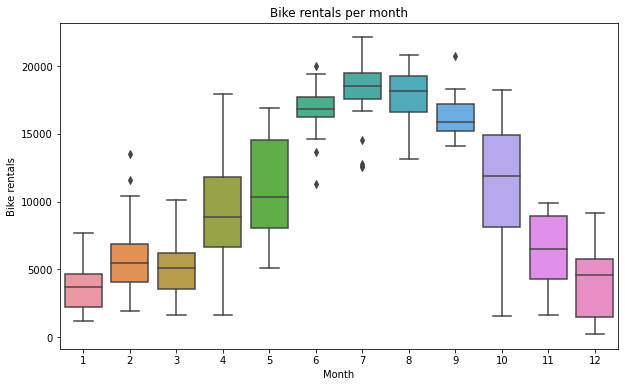

In [27]:
rentals_month_bp = chi_data.groupby(['Date','Month'])['bike_id'].count()
rentals_month_bp = pd.DataFrame(rentals_month_bp)

fig, ax = plt.subplots(figsize = (10,6))

sns.boxplot(x = rentals_month_bp.index.get_level_values('Month'), y =rentals_month_bp['bike_id'], ax = ax)
ax.set_title('Bike rentals per month')
ax.set_ylabel("Bike rentals")
plt.show()

#### Bike rentals per week

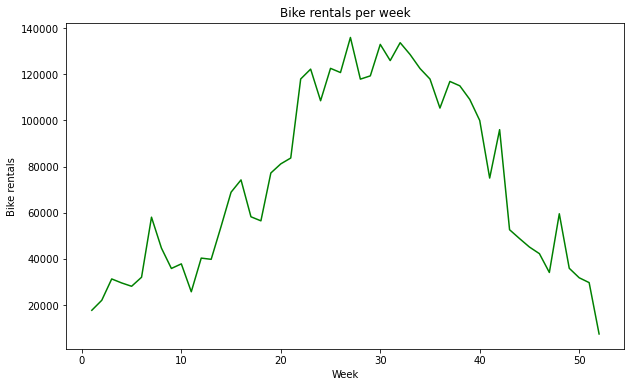

In [28]:
rentals_week = chi_data.groupby("Week")['bike_id'].count()
rentals_week = pd.DataFrame(rentals_week)

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(rentals_week, c = "green")

ax.set_title('Bike rentals per week')
ax.set_ylabel("Bike rentals")
ax.set_xlabel("Week")
plt.show()

#### Bike rentals per weekday

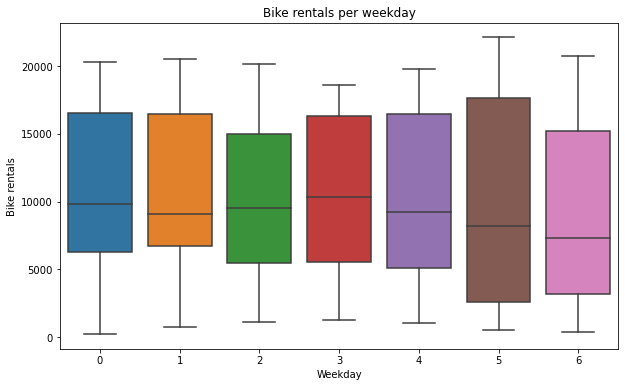

In [29]:
rentals_weekday = chi_data.groupby(['Weekday','Date'])['bike_id'].count()
rentals_weekday = pd.DataFrame(rentals_weekday)

fig, ax = plt.subplots(figsize = (10,6))

sns.boxplot(x = rentals_weekday.index.get_level_values('Weekday'), y =rentals_weekday['bike_id'], ax = ax)
ax.set_title('Bike rentals per weekday')
ax.set_ylabel("Bike rentals")

plt.show()

In [30]:
# legende Zahl - Wochentag

#### Bike rentals over year per day 

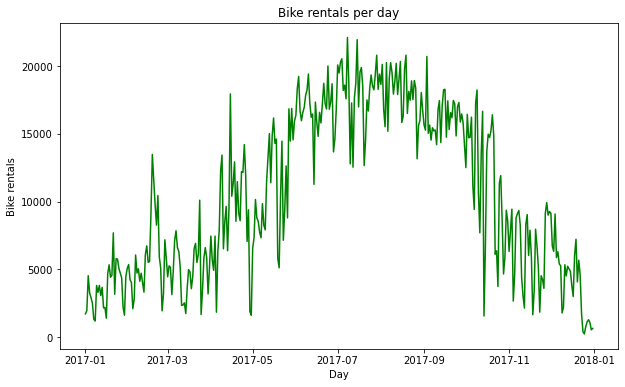

In [31]:
rentals_day = chi_data.groupby("Date")['bike_id'].count()
rentals_day = pd.DataFrame(rentals_day)

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(rentals_day, c = "green")

ax.set_title('Bike rentals per day')
ax.set_ylabel("Bike rentals")
ax.set_xlabel("Day")
plt.show()

#### Bike rentals per hour

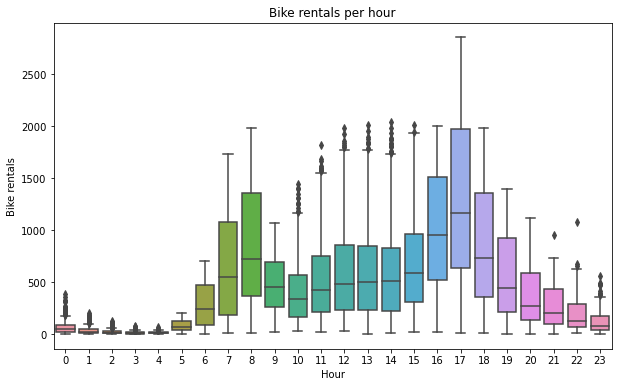

In [32]:
rentals_hour = chi_data.groupby(["Date","Hour"])['bike_id'].count()
rentals_hour =pd.DataFrame(rentals_hour)

fig, ax = plt.subplots(figsize = (10,6))


sns.boxplot(x = rentals_hour.index.get_level_values("Hour"), y =rentals_hour['bike_id'], ax = ax)
ax.set_title('Bike rentals per hour')
ax.set_ylabel("Bike rentals")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

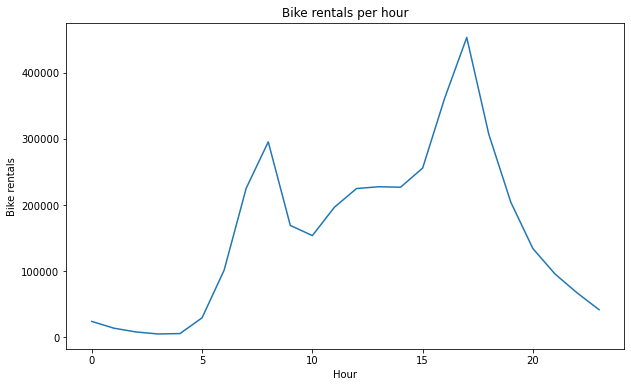

In [33]:
rentals_hour = chi_data.groupby(['Hour'])['bike_id'].count()
rentals_hour = pd.DataFrame(rentals_hour)

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(rentals_hour)
ax.set_title('Bike rentals per hour')
ax.set_ylabel("Bike rentals")
ax.set_xlabel("Hour")
plt.show

#### Correlation between weekday, hour & rentals???

### Duration/Travel time

#### Duration per week

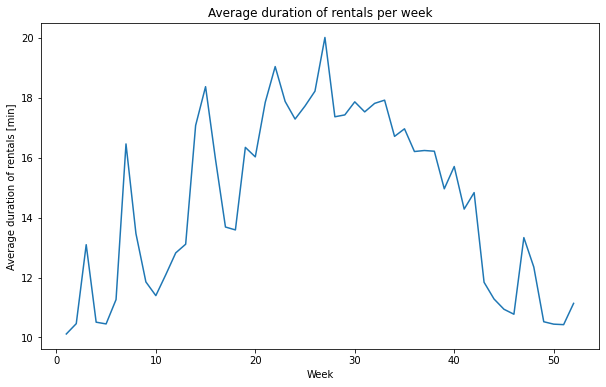

In [34]:
duration_week = chi_data.groupby("Week")["Duration_sec"].mean()/60
duration_week = pd.DataFrame(duration_week)

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(duration_week)

ax.set_title('Average duration of rentals per week')
ax.set_ylabel('Average duration of rentals [min]')
ax.set_xlabel('Week')
plt.show()

#### Duration per weekday

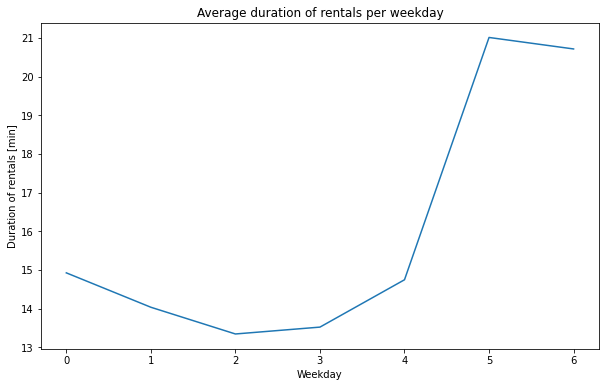

In [35]:
duration_weekday = chi_data.groupby("Weekday")["Duration_sec"].mean()/60
duration_weekday = pd.DataFrame(duration_weekday)

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(duration_weekday)

ax.set_title('Average duration of rentals per weekday')
ax.set_ylabel('Duration of rentals [min]')
ax.set_xlabel('Weekday')
plt.show()

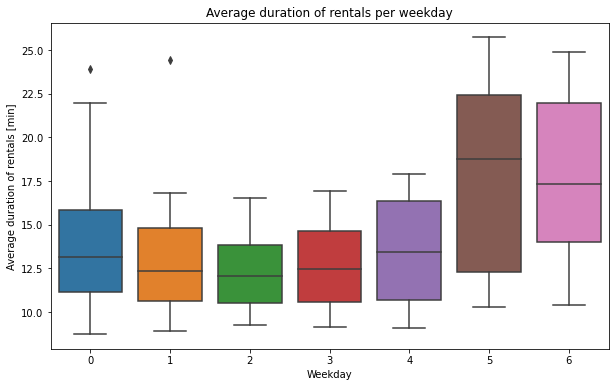

In [36]:
duration_weekday_bp = chi_data.groupby(["Date","Weekday"])['Duration_sec'].mean()/60
duration_weekday_bp =pd.DataFrame(duration_weekday_bp)

fig, ax = plt.subplots(figsize = (10,6))


sns.boxplot(x = duration_weekday_bp.index.get_level_values("Weekday"), y =duration_weekday_bp['Duration_sec'], ax = ax)
ax.set_title('Average duration of rentals per weekday')
ax.set_ylabel('Average duration of rentals [min]')
plt.show()

#### Duration per hour

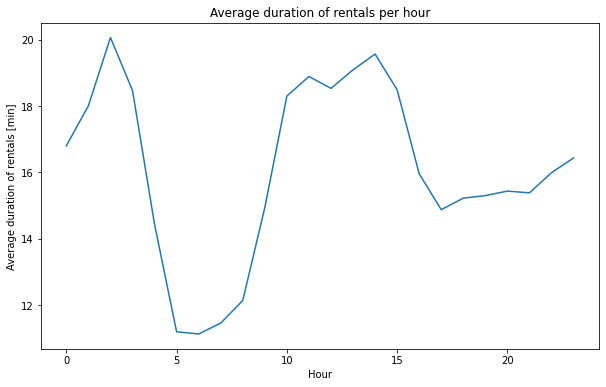

In [37]:
duration_hour = chi_data.groupby("Hour")["Duration_sec"].mean()/60
duration_hour = pd.DataFrame(duration_hour)

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(duration_hour, )

ax.set_title('Average duration of rentals per hour')
ax.set_ylabel('Average duration of rentals [min]')
ax.set_xlabel('Hour')
plt.show()

### Weather

#### Temperature monthly

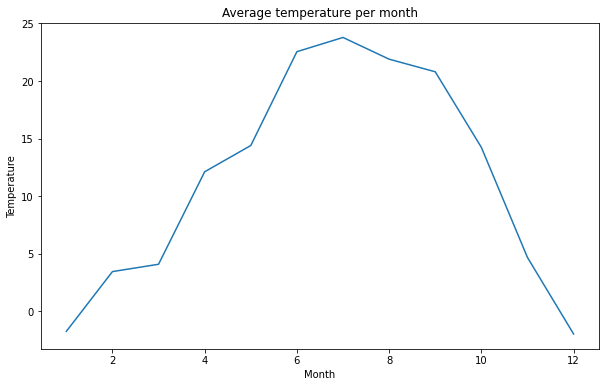

In [38]:
temp_month_mean = chi_weather_2017.groupby("Month")["mean_temp"].mean()

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(temp_month_mean)
ax.set_xlabel('Month')
ax.set_ylabel('Temperature')
ax.set_title("Average temperature per month")

plt.show()

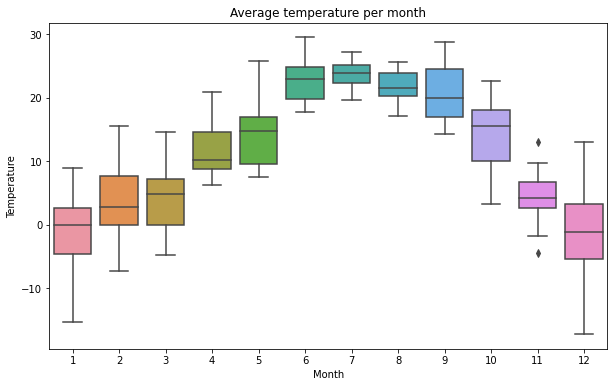

In [39]:
temp_month_mean_bp = chi_weather_2017.groupby(['Date','Month'])['mean_temp'].mean()
temp_month_mean_bp = pd.DataFrame(temp_month_mean_bp)

fig, ax = plt.subplots(figsize = (10,6))

sns.boxplot(x = temp_month_mean_bp.index.get_level_values('Month'), y =temp_month_mean_bp['mean_temp'], ax = ax)

ax.set_title('Average temperature per month')
ax.set_ylabel("Temperature")
ax.set_xlabel("Month")
plt.show()

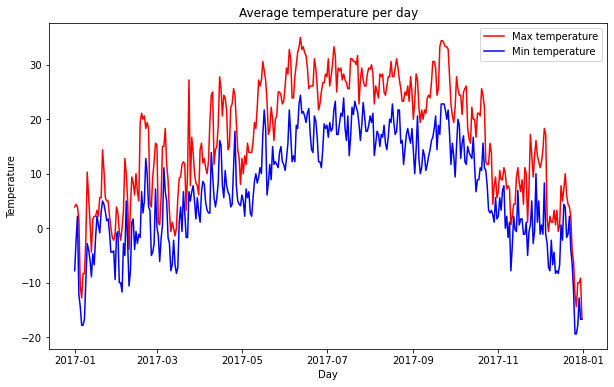

In [40]:
temp_day_min = chi_weather_2017.groupby("Date")["mean_temp"].min()

temp_day_max = chi_weather_2017.groupby("Date")["mean_temp"].max()

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(temp_day_max, c = "red", label = "Max temperature")
ax.plot(temp_day_min, c = "blue", label = "Min temperature")
plt.legend()
ax.set_title('Average temperature per day')
ax.set_ylabel("Temperature")
ax.set_xlabel('Day')

plt.show()

#### Temperature weekly

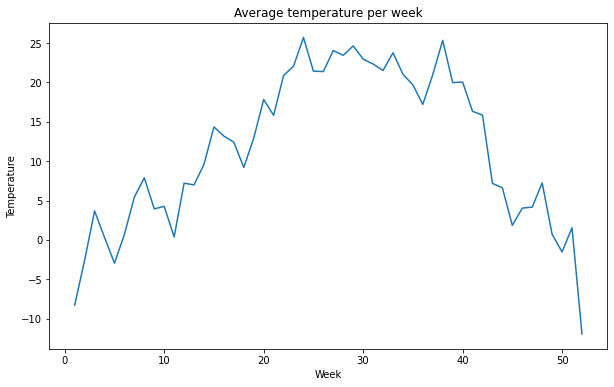

In [41]:
temp_week_mean = chi_weather_2017.groupby("Week")["mean_temp"].mean()

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(temp_week_mean)
ax.set_ylabel("Temperature")
ax.set_xlabel('Week')
ax.set_title('Average temperature per week')
plt.show()

#### Temperature daily

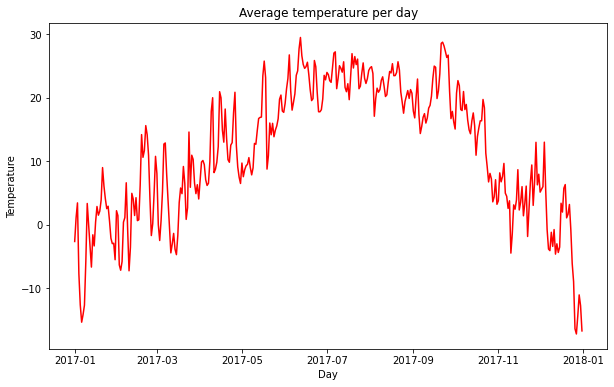

In [42]:
temp_day_mean = chi_weather_2017.groupby("Date")["mean_temp"].mean()

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(temp_day_mean, c = "red")
ax.set_title('Average temperature per day')
ax.set_ylabel("Temperature")
ax.set_xlabel('Day')

plt.show()

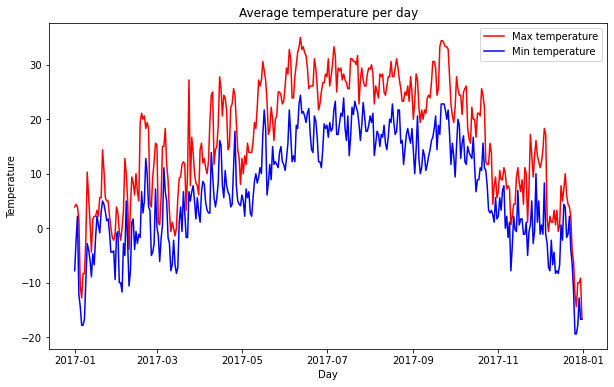

In [43]:
temp_day_min = chi_weather_2017.groupby("Date")["mean_temp"].min()

temp_day_max = chi_weather_2017.groupby("Date")["mean_temp"].max()

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(temp_day_max, c = "red", label = "Max temperature")
ax.plot(temp_day_min, c = "blue", label = "Min temperature")
plt.legend()
ax.set_title('Average temperature per day')
ax.set_ylabel("Temperature")
ax.set_xlabel('Day')

plt.show()

#### Precip monthly

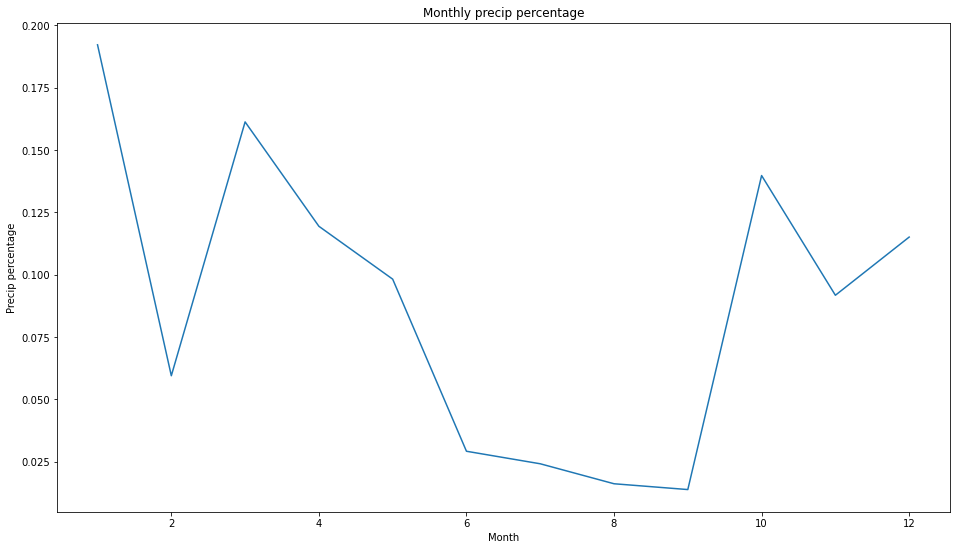

In [44]:
precip_month_mean = chi_weather_2017.groupby("Month")["precip"].mean()

fig, ax = plt.subplots(figsize = (16,9))

ax.plot(precip_month_mean)
ax.set_xlabel('Month')
ax.set_ylabel('Precip percentage')
ax.set_title("Monthly precip percentage")

plt.show()

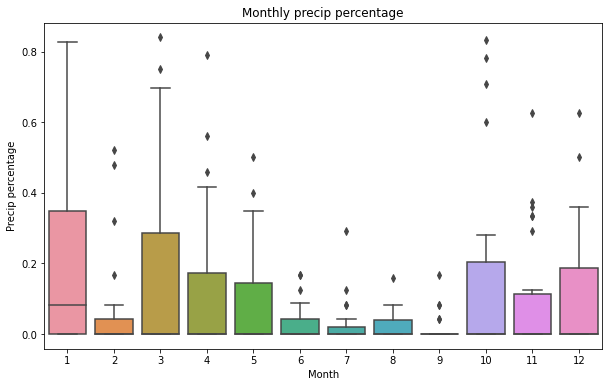

In [45]:
precip_month_mean_bp = chi_weather_2017.groupby(['Date','Month'])['precip'].mean()
precip_month_mean_bp = pd.DataFrame(precip_month_mean_bp)

fig, ax = plt.subplots(figsize = (10,6))

sns.boxplot(x = precip_month_mean_bp.index.get_level_values('Month'), y =precip_month_mean_bp['precip'], ax = ax)

ax.set_xlabel('Month')
ax.set_ylabel('Precip percentage')
ax.set_title("Monthly precip percentage")
plt.show()

#### Precip weekly

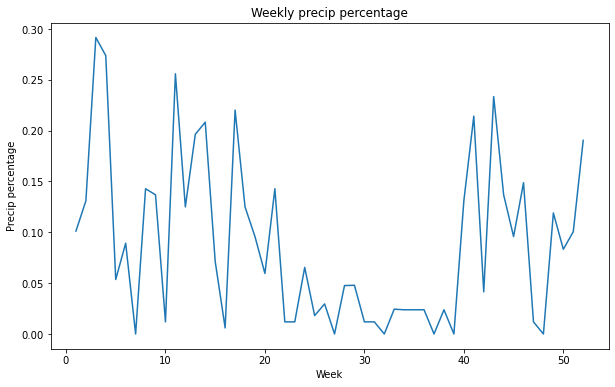

In [46]:
precip_week_mean = chi_weather_2017.groupby("Week")["precip"].mean()

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(precip_week_mean)
ax.set_title('Weekly precip percentage')
ax.set_ylabel("Precip percentage")
ax.set_xlabel('Week')
plt.show()

#### Precip daily

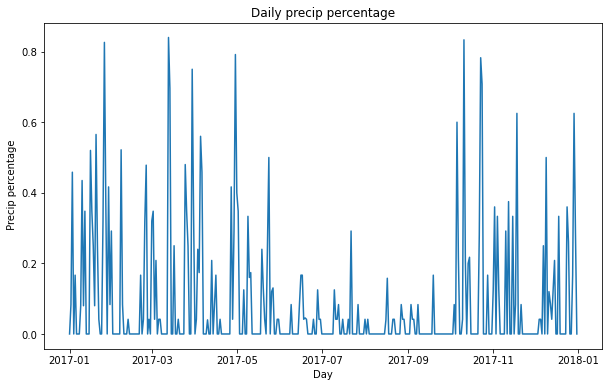

In [47]:
precip_day_mean = chi_weather_2017.groupby("Date")["precip"].mean()

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(precip_day_mean)
ax.set_title('Daily precip percentage')
ax.set_ylabel(" Precip percentage")
ax.set_xlabel('Day')
plt.show()

### Correlation between rentals and weather 

#### Rescaling

In [48]:
rentals_day_resc = (rentals_day-rentals_day.min())/(rentals_day.max()-rentals_day.min())

rentals_week_resc = ((rentals_week-rentals_week.min())/(rentals_week.max()-rentals_week.min()))

rentals_month_resc = ((rentals_month-rentals_month.min())/(rentals_month.max()-rentals_month.min()))

precip_day_resc = (precip_day_mean-precip_day_mean.min())/(precip_day_mean.max()-precip_day_mean.min())

precip_week_resc = (precip_week_mean-precip_week_mean.min())/(precip_week_mean.max()-precip_week_mean.min())

precip_month_resc = (precip_month_mean-precip_month_mean.min())/(precip_month_mean.max()-precip_month_mean.min())

temp_day_resc = (temp_day_mean-temp_day_mean.min())/(temp_day_mean.max()-temp_day_mean.min())

temp_week_resc = (temp_week_mean-temp_week_mean.min())/(temp_week_mean.max()-temp_week_mean.min())

temp_month_resc = ((temp_month_mean-temp_month_mean.min())/(temp_month_mean.max()-temp_month_mean.min()))

#### Rentals and temperatur

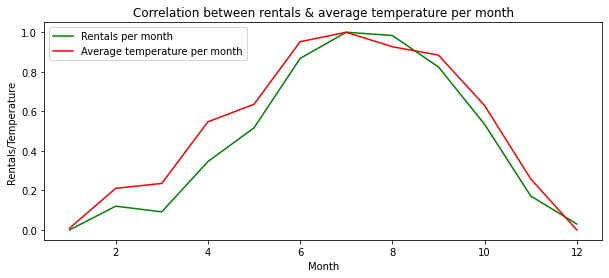

In [49]:
fig, ax = plt.subplots(figsize = (10,4))

ax.plot(rentals_month_resc, c = 'green', label='Rentals per month')
ax.plot(temp_month_resc, c = 'red', label='Average temperature per month')

ax.set_title('Correlation between rentals & average temperature per month')
ax.set_xlabel('Month')
ax.set_ylabel('Rentals/Temperature')
ax.legend()

plt.show()

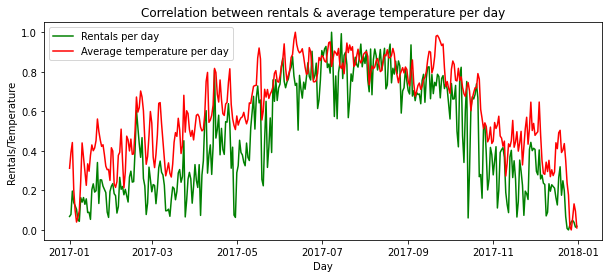

In [50]:
fig, ax = plt.subplots(figsize = (10,4))

ax.plot(rentals_day_resc, c = 'green', label='Rentals per day')
ax.plot(temp_day_resc, c = 'red', label='Average temperature per day')

ax.set_title('Correlation between rentals & average temperature per day')
ax.set_xlabel('Day')
ax.set_ylabel('Rentals/Temperature')
ax.legend()

plt.show()

In [51]:
#Put weather & rental data into the same data frame
temp_rentals_day = chi_weather_2017.groupby(["Date"])["mean_temp"].mean()
temp_rentals_day = pd.DataFrame(temp_rentals_day)
temp_rentals_day ["Rentals"] = chi_data.groupby(['Date'])['bike_id'].count()
temp_rentals_day ["IsWeekday"] = chi_data.groupby(['Date'])['IsWeekday'].max()

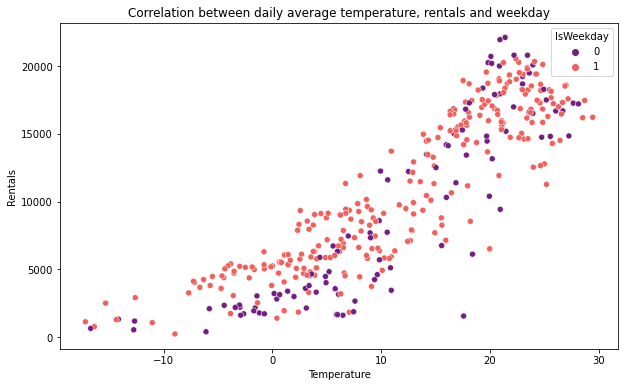

In [52]:

fig, ax = plt.subplots(figsize = (10,6))

sns.scatterplot(x = temp_rentals_day["mean_temp"], y= temp_rentals_day["Rentals"], hue = temp_rentals_day["IsWeekday"],palette="magma" )
ax.set_title("Correlation between daily average temperature, rentals and weekday")
ax.set_xlabel("Temperature")
plt.show()

#### Rentals and precip

In [53]:
#Put precip & rental data into the same data frame
precip_rentals_day = chi_weather_2017.groupby(["Date"])["precip"].mean()
precip_rentals_day = pd.DataFrame(precip_rentals_day)
precip_rentals_day ["Rentals"] = chi_data.groupby(['Date'])['bike_id'].count()
precip_rentals_day ["IsWeekday"] = chi_data.groupby(['Date'])['IsWeekday'].max()

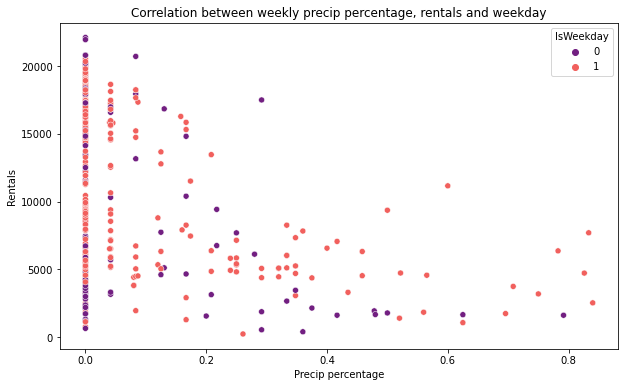

In [54]:

fig, ax = plt.subplots(figsize = (10,6))

sns.scatterplot(x = precip_rentals_day["precip"], y= precip_rentals_day["Rentals"], hue = precip_rentals_day["IsWeekday"],palette="magma" )
ax.set_title("Correlation between weekly precip percentage, rentals and weekday")
ax.set_xlabel("Precip percentage")
plt.show()

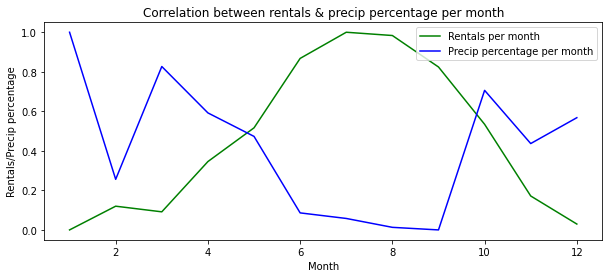

In [55]:
fig, ax = plt.subplots(figsize = (10,4))

ax.plot(rentals_month_resc, c = 'green', label='Rentals per month')
ax.plot(precip_month_resc, c = 'blue', label='Precip percentage per month')

ax.set_title('Correlation between rentals & precip percentage per month')
ax.set_xlabel('Month')
ax.set_ylabel('Rentals/Precip percentage')
ax.legend()

plt.show()

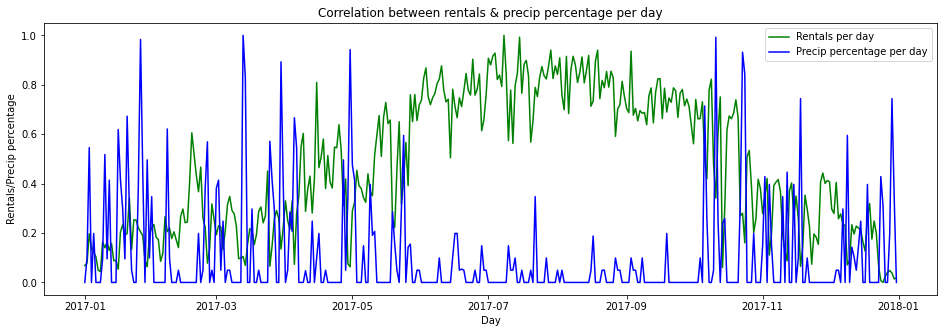

In [56]:
fig, ax = plt.subplots(figsize = (16,5))

ax.plot(rentals_day_resc, c = 'green', label='Rentals per day')
ax.plot(precip_day_resc, c = 'blue', label='Precip percentage per day')

ax.set_title('Correlation between rentals & precip percentage per day')
ax.set_xlabel('Day')
ax.set_ylabel('Rentals/Precip percentage')
ax.legend()

plt.show()

### Correlation between rental duration and weather 

In [57]:
duration_week_resc = (duration_week-duration_week.min())/(duration_week.max()-duration_week.min())

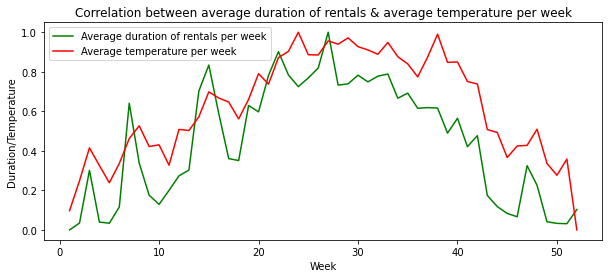

In [58]:
fig, ax = plt.subplots(figsize = (10,4))

ax.plot(duration_week_resc, c = 'green', label='Average duration of rentals per week')
ax.plot(temp_week_resc, c = 'red', label='Average temperature per week')

ax.set_title('Correlation between average duration of rentals & average temperature per week')
ax.set_xlabel('Week')
ax.set_ylabel('Duration/Temperature')
ax.legend()

plt.show()

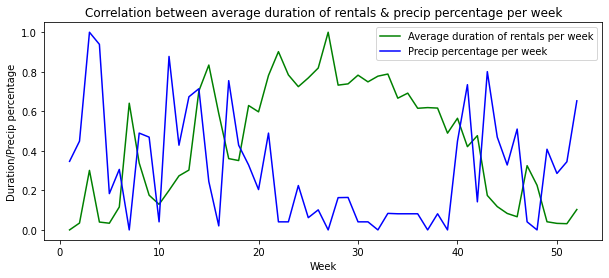

In [59]:
fig, ax = plt.subplots(figsize = (10,4))

ax.plot(duration_week_resc, c = 'green', label='Average duration of rentals per week')
ax.plot(precip_week_resc, c = 'blue', label='Precip percentage per week')

ax.set_title('Correlation between average duration of rentals & precip percentage per week')
ax.set_xlabel('Week')
ax.set_ylabel('Duration/Precip percentage')
ax.legend()

plt.show()

## Geographical demand patterns (Emilio & Alex)

In [60]:
chi_stations = pd.read_csv("chicago_2017.csv")

#### Creating location dictionary for location
!!! This must be done only once, for further usage simply read in the created json file (see next section) !!!

In [61]:
# example api request
geocode("Universität zu Köln", provider="nominatim", user_agent='my_request')

,geometry,address
0,POINT (6.92817 50.92804),"Universität zu Köln, Heimbacher Straße, Kriel,..."


In [62]:
def getLocation(x):
    try:
        location = geocode(x + ", Chicago", provider="nominatim", user_agent='my_request')
        point = location.geometry.iloc[0]
        return (f"{round(point.y, 5)} {round(point.x, 5)}")
    except:
        return 'NaN'

In [63]:
## commenting out to prevent running everything all the time

In [64]:
# UniqueAdresses = chi_stations['start_station_name'].unique()
# locDict = dict(zip(UniqueAdresses, pd.Series(UniqueAdresses).swifter.apply(lambda x: getLocation(x))))

In [65]:
## check if the list of stations are identical
# UniqueAdresses2 = chi_stations['end_station_name'].unique()
# locDict2 = dict(zip(UniqueAdresses2, pd.Series(UniqueAdresses2).swifter.apply(lambda x: getLocation(x))))


# set(locDict.keys()) == set(locDict2.keys())

In [66]:
## storing the location dictionary into a json file 
## for better look you should beaufify the json with some online tools
# with open('locDict.json', 'w') as file:
#      file.write(json.dumps(locDict))

#### Accessing and formatting the location data from our created json dictionary

In [67]:
# retrieve the location dictionary from the json file
with open('locDict.json', 'r') as file:
     newLocDict = json.loads(file.read())

In [68]:
# formatting the retrieved data into location tuples
def convertToTuple(x):
    if not x == "NaN":
        return tuple(map(float, x.split(" ")))
    else:
        return float('NaN')

In [69]:
chi_stations['start_station_coordinates'] = chi_stations['start_station_name'].map(newLocDict)
chi_stations['start_station_coordinates'] = chi_stations['start_station_coordinates'].swifter.apply(lambda x: convertToTuple(x))

Pandas Apply:   0%|          | 0/3829014 [00:00<?, ?it/s]

In [70]:
missingLocations = chi_stations[chi_stations["start_station_coordinates"].isnull()==True]["start_station_name"].count()
print(f"There are still {missingLocations} 'NaN' values in our coordinates where geocode didn't find a location according to the address")

There are still 196865 'NaN' values in our coordinates where geocode didn't find a location according to the address


In [71]:
chi_stations = chi_stations[chi_stations["start_station_coordinates"].isnull()==False]

### Mapping our stations

mapping out the stations in chicago

In [72]:
positions = list(chi_stations["start_station_coordinates"].unique())

chi_stations_map = folium.Map(location=(41.8856, -87.6415),  
                                tiles='Stamen Toner',
                                zoom_start=12, 
                                control_scale=True, 
                                max_zoom=20)

for position in positions:
    folium.CircleMarker(radius=5, location=position, popup='The Waterfront', 
                                 color='crimson', fill_color='crimson').add_to(chi_stations_map)
    
chi_stations_map

usage of every station visualized in a heatmap

In [73]:
chi_heat_map = folium.Map(location=(41.8856, -87.6415),
                            tiles='OpenStreetMap',
                            zoom_start=12,
                            control_scale=True,
                            max_zoom=20)

In [74]:
# get values for the new dataframe
chi_stations_usage = chi_stations.groupby(["start_station_name"])["bike_id"].count()
chi_stations_usage = pd.DataFrame({'start_station_name':chi_stations_usage.index, 'bike_id_count':chi_stations_usage.values})

# retrieve location data and convert it
chi_stations_usage["start_station_coordinates"] = chi_stations_usage["start_station_name"].map(newLocDict)
chi_stations_usage['start_station_coordinates'] = chi_stations_usage['start_station_coordinates'].swifter.apply(lambda x: convertToTuple(x))

# zip location and bike_id_count for heatmap
chi_stations_usage['heatmap_data'] = [a + (b,) for a, b in zip(chi_stations_usage['start_station_coordinates'], chi_stations_usage['bike_id_count'])]

Pandas Apply:   0%|          | 0/537 [00:00<?, ?it/s]

In [75]:
# replacing first entry with CircleMarker in order to keep heatmap weighting in reasonable scale
chi_stations_usage.sort_values("bike_id_count", ascending=False).head()

,start_station_name,bike_id_count,start_station_coordinates,heatmap_data
474,Streeter Dr & Grand Ave,97571,"(41.89224, -87.61195)","(41.89224, -87.61195, 97571)"
284,Lake Shore Dr & Monroe St,53400,"(41.88094, -87.61678)","(41.88094, -87.61678, 53400)"
77,Canal St & Adams St,50911,"(41.87923, -87.64002)","(41.87923, -87.64002, 50911)"
135,Clinton St & Washington Blvd,49832,"(41.88346, -87.64116)","(41.88346, -87.64116, 49832)"
476,Theater on the Lake,47908,"(41.92718, -87.63074)","(41.92718, -87.63074, 47908)"


In [76]:
# adding deleted point
folium.CircleMarker(radius=15, 
                    location=chi_stations_usage.start_station_coordinates[chi_stations_usage['bike_id_count'].idxmax()],
                    popup='Outliner',
                    color='crimson', 
                    fill_color='crimson').add_to(chi_heat_map)

chi_stations_usage = chi_stations_usage.drop(chi_stations_usage['bike_id_count'].idxmax())

In [77]:
# adding heatmap values
chi_heat_map.add_child(plugins.HeatMap(chi_stations_usage["heatmap_data"], radius=25, blur = 15, min_opacity = .3))
chi_heat_map

# `KPIs`

### Total bike usage

In [78]:
chi_data["date_hour"] = chi_data["start_time"].dt.floor("H")

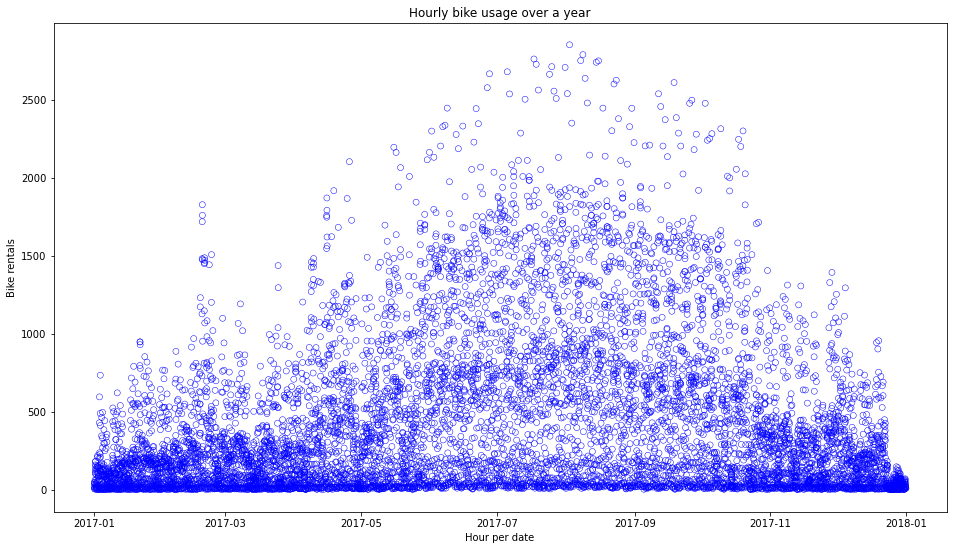

,Bike Usage
date_hour,
2017-01-01 00:00:00,46
2017-01-01 01:00:00,46
2017-01-01 02:00:00,36
2017-01-01 03:00:00,18
2017-01-01 04:00:00,6
...,...
2017-12-31 19:00:00,20
2017-12-31 20:00:00,20
2017-12-31 21:00:00,13


In [102]:
rentals_date_hour = chi_data.groupby("date_hour")['bike_id'].count()
rentals_date_hour = pd.DataFrame(rentals_date_hour)

fig, ax = plt.subplots(figsize = (16,9))


sns.scatterplot(x = rentals_date_hour.index.get_level_values("date_hour"), y =rentals_date_hour['bike_id'], ax = ax, color = "none", ec = "blue")
ax.set_title('Hourly bike usage over a year')
ax.set_ylabel("Bike rentals")
ax.set_xlabel("Hour per date")
plt.show()
rentals_date_hour.columns = ['Bike Usage']
rentals_date_hour

In [80]:
rentals_date_hour["date_hour"] =rentals_date_hour.index

In [81]:
rentals_date_hour["Hour"] = rentals_date_hour['date_hour'].swifter.apply(lambda dt: dt.hour)
rentals_date_hour["Month"] = rentals_date_hour['date_hour'].swifter.apply(lambda dt: dt.month)
rentals_date_hour["Day"] = rentals_date_hour['date_hour'].swifter.apply(lambda dt: dt.day)
rentals_date_hour.pop("date_hour")

Pandas Apply:   0%|          | 0/8743 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8743 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8743 [00:00<?, ?it/s]

date_hour
2017-01-01 00:00:00   2017-01-01 00:00:00
2017-01-01 01:00:00   2017-01-01 01:00:00
2017-01-01 02:00:00   2017-01-01 02:00:00
2017-01-01 03:00:00   2017-01-01 03:00:00
2017-01-01 04:00:00   2017-01-01 04:00:00
                              ...        
2017-12-31 19:00:00   2017-12-31 19:00:00
2017-12-31 20:00:00   2017-12-31 20:00:00
2017-12-31 21:00:00   2017-12-31 21:00:00
2017-12-31 22:00:00   2017-12-31 22:00:00
2017-12-31 23:00:00   2017-12-31 23:00:00
Name: date_hour, Length: 8743, dtype: datetime64[ns]

In [82]:
#Function that returns the total bike usage of specified day, month and hour.
def calculateNumberRentalsSpecificHour(day, month, hour):
    x = rentals_date_hour[(rentals_date_hour["Day"] == day) & (rentals_date_hour["Month"] == month) & (rentals_date_hour["Hour"] == hour)]
    y = x["bike_id"]
    y = pd.DataFrame(y)
    return y

In [83]:
#Output for 02.01.2017 hour 1
calculateNumberRentalsSpecificHour(2, 1, 1)

,bike_id
date_hour,
2017-01-02 01:00:00,10


### Fleet utilization

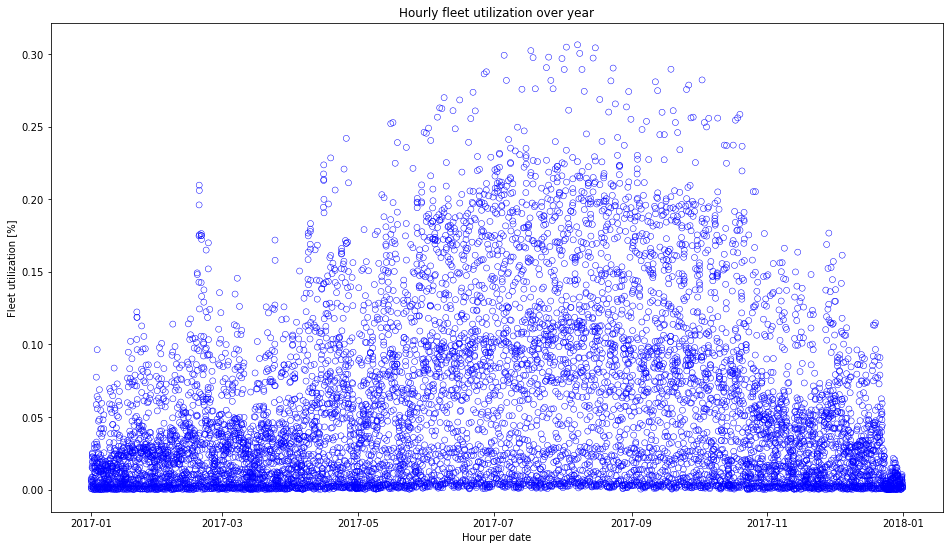

In [84]:
fleet_utilization = chi_data.groupby("date_hour")['bike_id'].nunique()/bikes
fleet_utilization =pd.DataFrame(fleet_utilization)

fig, ax = plt.subplots(figsize = (16,9))


sns.scatterplot(x = fleet_utilization.index.get_level_values("date_hour"), y =fleet_utilization['bike_id'], ax = ax, color = "none", ec = "blue")
ax.set_title('Hourly fleet utilization over year')
ax.set_ylabel("Fleet utilization [%]")
ax.set_xlabel("Hour per date")
plt.show()

In [85]:
fleet_utilization["date_hour"] =fleet_utilization.index
fleet_utilization["Year"] = fleet_utilization['date_hour'].swifter.apply(lambda dt: dt.year)
fleet_utilization["Hour"] = fleet_utilization['date_hour'].swifter.apply(lambda dt: dt.hour)
fleet_utilization["Month"] = fleet_utilization['date_hour'].swifter.apply(lambda dt: dt.month)
fleet_utilization["Day"] = fleet_utilization['date_hour'].swifter.apply(lambda dt: dt.day)
#fleet_utilization.pop("date_hour")
fleet_utilization

Pandas Apply:   0%|          | 0/8743 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8743 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8743 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8743 [00:00<?, ?it/s]

,bike_id,date_hour,Year,Hour,Month,Day
date_hour,,,,,,
2017-01-01 00:00:00,0.007368,2017-01-01 00:00:00,2017,0,1,1
2017-01-01 01:00:00,0.006728,2017-01-01 01:00:00,2017,1,1,1
2017-01-01 02:00:00,0.005606,2017-01-01 02:00:00,2017,2,1,1
2017-01-01 03:00:00,0.002883,2017-01-01 03:00:00,2017,3,1,1
2017-01-01 04:00:00,0.000801,2017-01-01 04:00:00,2017,4,1,1
...,...,...,...,...,...,...
2017-12-31 19:00:00,0.002563,2017-12-31 19:00:00,2017,19,12,31
2017-12-31 20:00:00,0.002883,2017-12-31 20:00:00,2017,20,12,31
2017-12-31 21:00:00,0.001922,2017-12-31 21:00:00,2017,21,12,31


In [86]:
fu_daily = fleet_utilization.groupby(['Year','Month','Day'])['bike_id'].mean()
fu_daily = pd.DataFrame(fu_daily)
fu_daily["Month"] = fu_daily.index.get_level_values('Month')
fu_daily["Day"] = fu_daily.index.get_level_values('Day')
fu_daily["Year"] = 2017

fu_daily['Date'] = pd.to_datetime(fu_daily[['Year','Month','Day']])


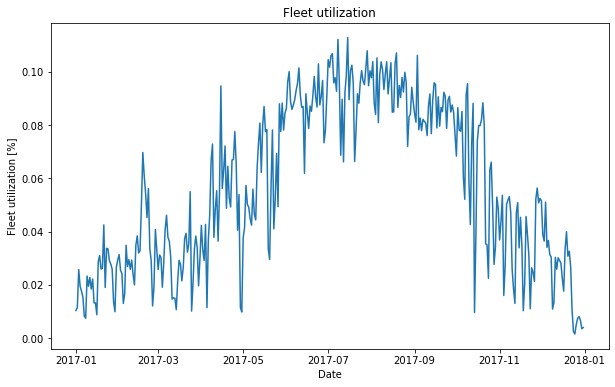

In [87]:
fig, ax = plt.subplots(figsize = (10,6))

sns.lineplot(x = fu_daily['Date'], y =fu_daily['bike_id'], ax = ax)
ax.set_title('Fleet utilization')
ax.set_ylabel('Fleet utilization [%]')
plt.show()

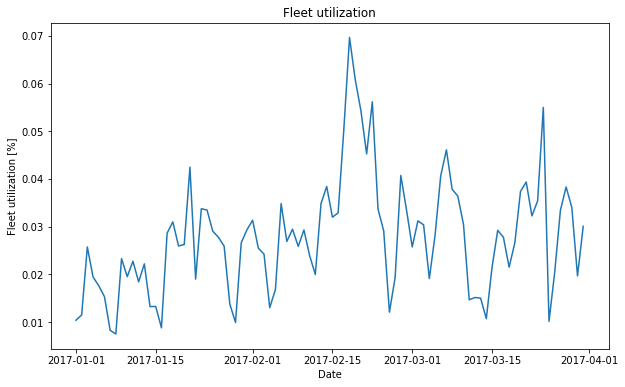

In [88]:
first_date_q1 = datetime(year=2017, day=1, month=1, hour=0)
last_date_q1 = datetime(year=2017, day=31, month=3, hour=23)

fu_daily_q1 = fu_daily[(fu_daily['Date']>=first_date_q1)&(fu_daily["Date"] <= last_date_q1)]

fig, ax = plt.subplots(figsize = (10,6))

sns.lineplot(x = fu_daily_q1['Date'], y =fu_daily_q1['bike_id'], ax = ax)
ax.set_title('Fleet utilization')
ax.set_ylabel('Fleet utilization [%]')
plt.show()

In [89]:
#Function that returns the relative utilization of the fleet for a specified day, month and hour.
def calculateFleetUtilization(day, month, hour):
    x = fleet_utilization[(fleet_utilization["Day"] == day) & (fleet_utilization["Month"] == month) & (fleet_utilization["Hour"] == hour)]
    y = x["bike_id"]
    y = pd.DataFrame(y)
    return y

In [90]:
#Output for 15.08.2017 hour 8
calculateFleetUtilization(15,8,8)

,bike_id
date_hour,
2017-08-15 08:00:00,0.229217


### Duration of rentals

In [91]:
duration = chi_data.groupby("date_hour")['Duration_sec'].mean()
duration =pd.DataFrame(duration)
duration["mean_minutes"]= duration["Duration_sec"]/60
duration["min_minutes"]=  chi_data.groupby("date_hour")['Duration_sec'].min()/60
duration["max_minutes"]=  chi_data.groupby("date_hour")['Duration_sec'].max()/60
duration

,Duration_sec,mean_minutes,min_minutes,max_minutes
date_hour,,,,
2017-01-01 00:00:00,1569.782609,26.163043,1.466667,646.350000
2017-01-01 01:00:00,685.739130,11.428986,2.083333,30.083333
2017-01-01 02:00:00,503.777778,8.396296,1.183333,27.133333
2017-01-01 03:00:00,694.888889,11.581481,1.833333,28.833333
2017-01-01 04:00:00,508.666667,8.477778,1.283333,16.850000
...,...,...,...,...
2017-12-31 19:00:00,741.000000,12.350000,3.000000,35.000000
2017-12-31 20:00:00,759.000000,12.650000,3.000000,30.000000
2017-12-31 21:00:00,636.923077,10.615385,2.000000,41.000000


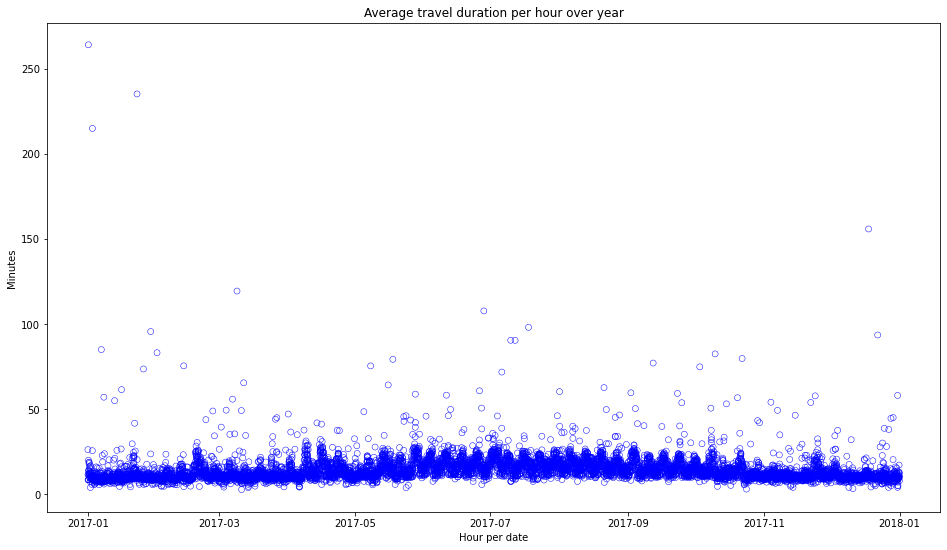

In [92]:
fig, ax = plt.subplots(figsize = (16,9))


sns.scatterplot(x = duration.index.get_level_values("date_hour"), y =duration['mean_minutes'], ax = ax, color = "none", ec = "blue")
ax.set_title('Average travel duration per hour over year')
ax.set_ylabel("Minutes")
ax.set_xlabel("Hour per date")
plt.show()

In [93]:
duration["date_hour"] =duration.index
duration["Hour"] = duration['date_hour'].swifter.apply(lambda dt: dt.hour)
duration["Month"] = duration['date_hour'].swifter.apply(lambda dt: dt.month)
duration["Day"] = duration['date_hour'].swifter.apply(lambda dt: dt.day)
duration.pop("date_hour")

Pandas Apply:   0%|          | 0/8743 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8743 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8743 [00:00<?, ?it/s]

date_hour
2017-01-01 00:00:00   2017-01-01 00:00:00
2017-01-01 01:00:00   2017-01-01 01:00:00
2017-01-01 02:00:00   2017-01-01 02:00:00
2017-01-01 03:00:00   2017-01-01 03:00:00
2017-01-01 04:00:00   2017-01-01 04:00:00
                              ...        
2017-12-31 19:00:00   2017-12-31 19:00:00
2017-12-31 20:00:00   2017-12-31 20:00:00
2017-12-31 21:00:00   2017-12-31 21:00:00
2017-12-31 22:00:00   2017-12-31 22:00:00
2017-12-31 23:00:00   2017-12-31 23:00:00
Name: date_hour, Length: 8743, dtype: datetime64[ns]

In [94]:
#Function that returns the relative utilization of the fleet for a specified day, month and hour.
def calculateDuration(day, month, hour):
    x = duration[(duration["Day"] == day) & (duration["Month"] == month) & (duration["Hour"] == hour)]
    y = x["mean_minutes"]
    y = pd.DataFrame(y)
    y["min_minutes"] = x["min_minutes"]
    y["max_minutes"] = x["max_minutes"]

    return y

In [95]:
calculateDuration(1,1,0)

,mean_minutes,min_minutes,max_minutes
date_hour,,,
2017-01-01,26.163043,1.466667,646.35


### Rental distribution of costumers and subscribers

for better overview we are grouping by week

In [96]:
chi_usage = chi_data.groupby(["Week"])["bike_id"].count()
chi_usage_subs = chi_data[chi_data["user_type"]=="Subscriber"].groupby(["Week"])["bike_id"].count()
chi_usage_costu = chi_data[chi_data["user_type"]=="Customer"].groupby(["Week"])["bike_id"].count()

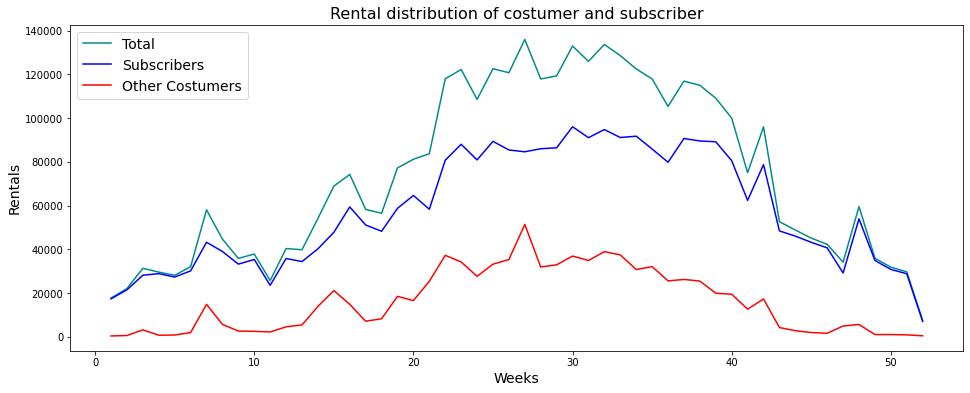

In [97]:
fig, ax = plt.subplots(figsize=(16,6))

ax.plot(chi_usage, label="Total", color='darkcyan')
ax.plot(chi_usage_subs, label="Subscribers", color='b')
ax.plot(chi_usage_costu, label="Other Costumers", color='r')

ax.set_title("Rental distribution of costumer and subscriber", fontsize=16)
ax.set_ylabel("Rentals", fontsize=14)
ax.set_xlabel("Weeks", fontsize=14)
ax.legend(fontsize=14, loc="upper left")
plt.show()

### Bike station utilization

In [98]:
chi_kpi_heat_map = folium.Map(location=(41.8856, -87.6415),
                            tiles='OpenStreetMap',
                            zoom_start=12,
                            control_scale=True,
                            max_zoom=20)

In [99]:
#Function that returns the relative utilization of the fleet for a specified day, month and hour.
def calculateStationUtilization(day, month, hour):
    x = chi_data[(chi_data["Day"] == day) & (chi_data["Month"] == month) & (chi_data["Hour"] == hour)]
    y = x.groupby(["start_station_name"])["bike_id"].count()
    y = pd.DataFrame({'start_station_name':y.index, 'bike_id_count':y.values})
    y["start_station_coordinates"] = y["start_station_name"].map(newLocDict)
    y['start_station_coordinates'] = y['start_station_coordinates'].swifter.progress_bar(False).apply(lambda x: convertToTuple(x))
    y = y[y["start_station_coordinates"].isnull()==False]
    y['heatmap_data'] = [a + (b,) for a, b in zip(y['start_station_coordinates'], y['bike_id_count'])]
    return y

In [100]:
chi_kpi_station_usage = calculateStationUtilization(15,7,16)

In [101]:
# adding heatmap values
chi_kpi_heat_map.add_child(plugins.HeatMap(chi_kpi_station_usage["heatmap_data"], radius=25, blur = 15, min_opacity = .3))
chi_kpi_heat_map

# `Predictive Analytics`

## Feature Engineering

In [177]:
reg_df = rentals_date_hour['Bike Usage']
reg_df = pd.DataFrame(reg_df)
reg_df['Temp'] = chi_weather_2017.groupby("date_time")['mean_temp'].mean()

reg_df.tail(50)

KeyError: 'Column not found: mean_temp'

In [161]:
chi_weather_2017.head()

,date_time,max_temp,min_temp,precip,Date,Month,Week,Hour,Weekday,mean_temp
17543,2017-01-01 00:00:00,-0.6,-0.6,0.0,2017-01-01,1,52,0,6,-0.6
17520,2017-01-01 01:00:00,-2.2,-2.2,0.0,2017-01-01,1,52,1,6,-2.2
17521,2017-01-01 02:00:00,-2.8,-2.8,0.0,2017-01-01,1,52,2,6,-2.8
17522,2017-01-01 03:00:00,-3.3,-3.3,0.0,2017-01-01,1,52,3,6,-3.3
17523,2017-01-01 04:00:00,-3.3,-3.3,0.0,2017-01-01,1,52,4,6,-3.3
